<a href="https://colab.research.google.com/github/juanknebel/text-mining-2020/blob/master/9_RNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# notebook settings -> GPU
%tensorflow_version 1.x
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
import matplotlib.pylab as plt
from sklearn.metrics import f1_score
from sklearn.naive_bayes import MultinomialNB

from nltk import word_tokenize, sent_tokenize
import nltk
nltk.download('punkt')

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from gensim.models.word2vec import Word2Vec
from gensim.models import KeyedVectors

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation, GlobalMaxPooling1D, Bidirectional, GRU, CuDNNGRU
from keras.layers.embeddings import Embedding
import tensorflow_datasets as tfds


TensorFlow 1.x selected.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Using TensorFlow backend.


In [0]:
# Split the training set into 60% and 40%, so we'll end up with 15,000 examples
# for training, 10,000 examples for validation and 25,000 examples for testing.
train_data, validation_data, test_data = tfds.load(
    name="imdb_reviews", 
    split=('train[:60%]', 'train[60%:]', 'test'),
    as_supervised=True)

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteCQZYPO/imdb_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteCQZYPO/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteCQZYPO/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    'text': Text(shape=(), dtype=tf.string),
})> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: Bad argument number for Name: 3, expecting 4


    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    'text': Text(shape=(), dtype=tf.string),
})> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: Bad argument number for Name: 3, expecting 4


    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    'text': Text(shape=(), dtype=tf.string),
})> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: Bad argument number for Name: 3, expecting 4


    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    'text': Text(shape=(), dtype=tf.string),
})> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: Bad argument number for Name: 3, expecting 4


    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    'text': Text(shape=(), dtype=tf.string),
})> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: Bad argument number for Name: 3, expecting 4


    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    'text': Text(shape=(), dtype=tf.string),
})> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: Bad argument number for Name: 3, expecting 4


    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    'text': Text(shape=(), dtype=tf.string),
})> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: Bad argument number for Name: 3, expecting 4


    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    'text': Text(shape=(), dtype=tf.string),
})> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: Bad argument number for Name: 3, expecting 4


    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    'text': Text(shape=(), dtype=tf.string),
})> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: Bad argument number for Name: 3, expecting 4


In [0]:
df_train = pd.DataFrame(list(tfds.as_numpy(train_data)),columns=['texto','clase'])
df_dev = pd.DataFrame(list(tfds.as_numpy(validation_data)),columns=['texto','clase'])
df_test = pd.DataFrame(list(tfds.as_numpy(test_data)),columns=['texto','clase'])

In [0]:
def format_and_clean(text):
    text = text.decode('utf-8').lower()
    # clean review
    text = re.sub('<.*?>',' ',text)
    return text


In [0]:
X_train_text = df_train.texto.apply(format_and_clean)
X_dev_text = df_dev.texto.apply(format_and_clean)
X_test_text = df_test.texto.apply(format_and_clean)

In [0]:
y_train = df_train.clase
y_dev = df_dev.clase
y_test = df_test.clase

In [0]:
vocab_size = 5000+1 # Adding 1 because of reserved 0 index
tokenizer = Tokenizer(num_words=vocab_size-1)
tokenizer.fit_on_texts(X_train_text)
X_train = tokenizer.texts_to_sequences(X_train_text)
X_dev = tokenizer.texts_to_sequences(X_dev_text)
X_test = tokenizer.texts_to_sequences(X_test_text)

In [0]:
print(X_train_text.iloc[2])
print("-------------------------------------------------------------------------")
print(X_train[2])

mann photographs the alberta rocky mountains in a superb fashion, and jimmy stewart and walter brennan give enjoyable performances as they always seem to do.   but come on hollywood - a mountie telling the people of dawson city, yukon to elect themselves a marshal (yes a marshal!) and to enforce the law themselves, then gunfighters battling it out on the streets for control of the town?   nothing even remotely resembling that happened on the canadian side of the border during the klondike gold rush. mr. mann and company appear to have mistaken dawson city for deadwood, the canadian north for the american wild west.  canadian viewers be prepared for a reefer madness type of enjoyable howl with this ludicrous plot, or, to shake your head in disgust.
-------------------------------------------------------------------------
[3521, 1, 4377, 3672, 7, 3, 955, 1657, 2, 1948, 1243, 2, 2112, 203, 745, 353, 13, 31, 213, 297, 5, 75, 17, 211, 19, 343, 3, 974, 1, 79, 4, 3792, 542, 5, 519, 3, 431, 3,

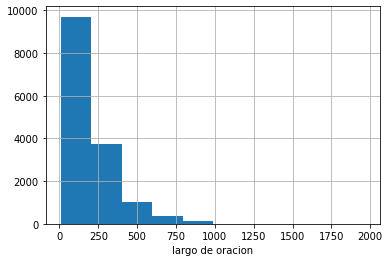

In [0]:

pd.Series([len(x)for x in X_train]).hist()
plt.xlabel('largo de documento');


In [0]:
# Fijamos el numero de tokens por instancia. Si tiene mas de 'maxlen' se recorta, si tiene menos se completa con ceros (padding)
maxlen=500
X_train_padded = pad_sequences(X_train,padding='post',maxlen=maxlen)
X_dev_padded   = pad_sequences(X_dev,padding='post',maxlen=maxlen)
X_test_padded  = pad_sequences(X_test,padding='post',maxlen=maxlen)

In [0]:
print(X_dev_padded[2])

[ 590 2053    3  216   11   26   12    5  646    7    1 3451  692    2
    8    6    3  216   26  306   69   10  700  532  122   29    3   48
 2132    2 3126   21  140    5    1  127 3974  306    3  460 1062    2
    1   63    4    3 1089 1584   22   94   84    3 1656  179    6   69
 4067 1287    2    3 1655   14    1 1480    3  474  946    1  127    1
   63  218    3  117    2    1 1440  198 1933    2    1 3278    6    2
 3490   13   43    8   12 1096   60    5 1917    1  483  131   17   11
 1252    3   16  284  311    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 

# Naive Bayes

In [0]:
count_vect = CountVectorizer(tokenizer=word_tokenize, max_features=5000)
X_train_NB = count_vect.fit_transform(X_train_text) # cuenta frecuencia de tokens y define el diccionario
X_dev_NB= count_vect.transform(X_dev_text) # cuenta frecuencia de tokens existentes en el diccionario


In [0]:
clf = MultinomialNB(alpha=1) # alpha es el smoothing parameter
NB_model = clf.fit(X_train_NB,y_train)
NB_F1 = f1_score(y_dev,NB_model.predict(X_dev_NB))
NB_F1

0.8253128497303897

## Recurrent Neural Network

In [0]:
embedding_dim = 100

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(CuDNNGRU(128))
model.add(Dense(10, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy',  metrics=['accuracy'])

In [0]:
# train
history = model.fit(X_train_padded, y_train,batch_size=100, epochs=15,validation_data=(X_dev_padded, y_dev)) 


Train on 15000 samples, validate on 10000 samples
Epoch 1/15
15000/15000 [==============================] - 6s 401us/step - loss: 0.1795 - accuracy: 0.9337 - val_loss: 0.3050 - val_accuracy: 0.8799
Epoch 2/15
15000/15000 [==============================] - 6s 400us/step - loss: 0.1136 - accuracy: 0.9632 - val_loss: 0.3574 - val_accuracy: 0.8780
Epoch 3/15
15000/15000 [==============================] - 6s 401us/step - loss: 0.0688 - accuracy: 0.9799 - val_loss: 0.4254 - val_accuracy: 0.8769
Epoch 4/15
15000/15000 [==============================] - 6s 398us/step - loss: 0.0393 - accuracy: 0.9896 - val_loss: 0.5006 - val_accuracy: 0.8761
Epoch 5/15
15000/15000 [==============================] - 6s 395us/step - loss: 0.0307 - accuracy: 0.9923 - val_loss: 0.5367 - val_accuracy: 0.8736
Epoch 6/15
15000/15000 [==============================] - 6s 392us/step - loss: 0.0289 - accuracy: 0.9927 - val_loss: 0.5438 - val_accuracy: 0.8679
Epoch 7/15
15000/15000 [==============================] - 6s 3

In [0]:
def plot_history(history):
  # Plot training & validation accuracy values
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()


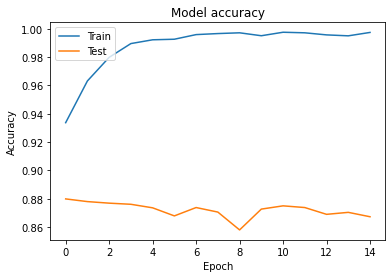

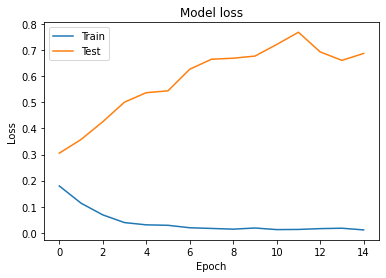

In [0]:
plot_history(history)

In [0]:
pred_gru = model.predict(X_dev_padded)
gru_F1 = f1_score(y_dev,pred_gru[:,0]>0.5)
gru_F1

0.8621298701298701

Bi-GRU

In [0]:
embedding_dim = 100
model_bigru = Sequential()
model_bigru.add(Embedding(vocab_size, embedding_dim, input_length=maxlen))
model_bigru.add(Bidirectional(CuDNNGRU(128, return_sequences = True)))
model_bigru.add(Bidirectional(CuDNNGRU(128)))
model_bigru.add(Dense(10, activation='relu'))
model_bigru.add(Dense(10, activation='relu'))
model_bigru.add(Dense(1, activation='sigmoid'))
model_bigru.compile(optimizer='adam', loss='binary_crossentropy',  metrics=['accuracy'])

In [0]:
history = model_bigru.fit(X_train_padded, y_train,batch_size=100, epochs=15,validation_data=(X_dev_padded, y_dev)) 


Train on 15000 samples, validate on 10000 samples
Epoch 1/15
 1300/15000 [=>............................] - ETA: 19s - loss: 0.2583 - accuracy: 0.9115

KeyboardInterrupt: ignored

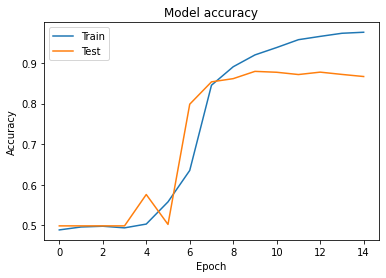

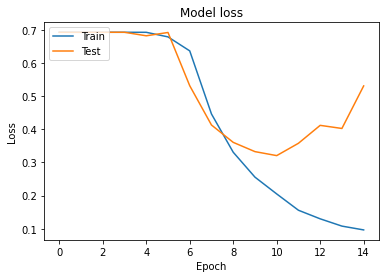

In [0]:
plot_history(history)

In [0]:
pred_bigru = model.predict(X_dev_padded)
bigru_F1 = f1_score(y_dev,pred_bigru[:,0]>0.5)
bigru_F1

0.8631707069682524

## Pre-trained embeddings

In [0]:
!wget https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz

--2020-05-20 00:18:23--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.113.61
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.113.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  13.7MB/s    in 1m 59s  

2020-05-20 00:20:22 (13.2 MB/s) - ‘GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [0]:
#load model
w2v_model = KeyedVectors.load_word2vec_format('./GoogleNews-vectors-negative300.bin.gz', binary=True)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in tokenizer.word_index.items():
    if i < vocab_size and word in w2v_model:
        embedding_matrix[i] = w2v_model[word]

In [0]:
model_bigru_emb = Sequential()
model_bigru_emb.add(Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=maxlen, trainable=False))
model_bigru_emb.add(Bidirectional(CuDNNGRU(128, return_sequences = True)))
model_bigru_emb.add(Dropout(0.3))
model_bigru_emb.add(Bidirectional(CuDNNGRU(128)))
model_bigru_emb.add(Dropout(0.3))
model_bigru_emb.add(Dense(10, activation='relu'))
model_bigru_emb.add(Dense(10, activation='relu'))
model_bigru_emb.add(Dense(1, activation='sigmoid'))
model_bigru_emb.compile(optimizer='adam', loss='binary_crossentropy',  metrics=['accuracy'])

In [0]:
history_emb = model_bigru_emb.fit(X_train_padded,y_train,epochs=15,validation_data=(X_dev_padded,y_dev),batch_size=100)

Train on 15000 samples, validate on 10000 samples
Epoch 1/15
15000/15000 [==============================] - 27s 2ms/step - loss: 0.6593 - accuracy: 0.5928 - val_loss: 0.6924 - val_accuracy: 0.5011
Epoch 2/15
15000/15000 [==============================] - 27s 2ms/step - loss: 0.6902 - accuracy: 0.5360 - val_loss: 0.6928 - val_accuracy: 0.5010
Epoch 3/15
15000/15000 [==============================] - 27s 2ms/step - loss: 0.6723 - accuracy: 0.5839 - val_loss: 0.6946 - val_accuracy: 0.4993
Epoch 4/15
15000/15000 [==============================] - 27s 2ms/step - loss: 0.6931 - accuracy: 0.5013 - val_loss: 0.6926 - val_accuracy: 0.5010
Epoch 5/15
15000/15000 [==============================] - 27s 2ms/step - loss: 0.6928 - accuracy: 0.5073 - val_loss: 0.6919 - val_accuracy: 0.5009
Epoch 6/15
15000/15000 [==============================] - 27s 2ms/step - loss: 0.6889 - accuracy: 0.5383 - val_loss: 0.6674 - val_accuracy: 0.5970
Epoch 7/15
15000/15000 [==============================] - 27s 2ms/st

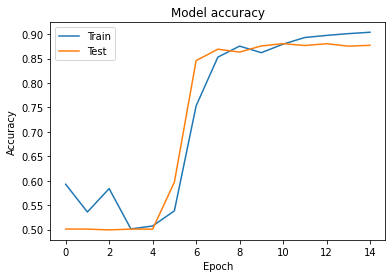

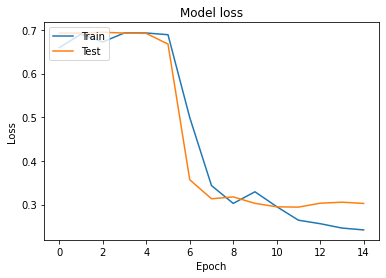

In [0]:
plot_history(history_emb)

In [0]:
pred_bigru_emb = model_bigru_emb.predict(X_dev_padded)
bigru_emb_F1 = f1_score(y_dev,pred_bigru_emb[:,0]>0.5)
bigru_emb_F1

0.8717734350506845

# En test

In [0]:
pred_y= model_bigru_emb.predict(X_test_padded)
test_F1 = f1_score(y_test,pred_y[:,0]>0.5)
test_F1

0.8753972236159893